# Auto-Complete 

Auto-complete is a feature in which an application predicts the rest of a word a user is typing (predictive text). In this project I aim to build a prototype of an auto-complete system. A key building block for an auto-complete system is a language model. A language model assigns the probability to a sequence of words, in a way that more "likely" sequences receive higher scores. This project uses N-grams, a simple but powerful method for language modeling.

**Dataset:** Text corpus from Twitter

In [1]:
# Importing libraries
import math
import random
import numpy as np
import pandas as pd

import nltk
nltk.download('punkt')
nltk.data.path.append('.')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Loading and Preprocessing the data

Steps involved:
1. Loading the data
2. Preprocessing the data <br>
  2.1. Split the data into sentences <br>
  2.2. Split each sentence into tokens (words) <br>
  2.3. Assign sentences into train or test sets (no validation set) <br>
  2.4. Handling OOV words 


### Loading the data
Loading the twitter data and viewing the first few sentences.

In [2]:
# Loading the data
with open("/content/en_US.twitter.txt", "r") as f:
  text = f.read()

# Exploring the text
print("Data type: ", type(text))
print("Number of letters: ", len(text))
print("-----------------------------------------------------------")
print("First 300 letters of the text\n")
print(text[:300])
print("-----------------------------------------------------------")

print("-----------------------------------------------------------")
print("Last 300 letters of the text\n")
print(text[-300:])
print("-----------------------------------------------------------")

Data type:  <class 'str'>
Number of letters:  164456396
-----------------------------------------------------------
First 300 letters of the text

How are you? Btw thanks for the RT. You gonna be in DC anytime soon? Love to see you. Been way, way too long.
When you meet someone special... you'll know. Your heart will beat more rapidly and you'll smile for no reason.
they've decided its more fun if I don't.
So Tired D; Played Lazer Tag & Ran A 
-----------------------------------------------------------
-----------------------------------------------------------
Last 300 letters of the text

od. I see the success you got poppin in yo area.
RT : Consumers are visual. They want data at their finger tips. Mobile is the only way to deliver this, 24/7.
u welcome
It is #RHONJ time!!
The key to keeping your woman happy= attention, affection, treat her like a queen and sex her like a pornstar!

-----------------------------------------------------------


The data is a long string that contains many tweets, with a line break between tweets.

### Preprocess the data

Step 1: Split the data into sentences using the "\n" delimiter

In [3]:
def split_to_sentences(text):
  """
  Split data by linebreak ("\n")
  
  Arguments:
    text - str
  Returns: 
    A list of sentences
  """
  sentences = text.split("\n")
  # Removing leading and trailing spaces from each sentence.
  sentences = [s.strip() for s in sentences]  
  # Drop sentences if they are empty strings. 
  sentences = [s for s in sentences if len(s) > 0]
  
  return sentences

Step 2: Split a sentence into a list of words (all tokens were converted to lowercase at first)


In [4]:
def tokenize_sentences(sentences): 
  """
  Tokenize sentences into tokens (words)
  
  Arguments:
    sentences: List of strings
  Returns:
    List of lists of tokens
  """
  tokenized_sentences = []

  for sentence in sentences:
    sentence = sentence.lower()  # Convert to lowercase letters.
    tokenized = nltk.word_tokenize(sentence)  # Convert to a list of words
    tokenized_sentences.append(tokenized)  # Append the list of words to the list of lists

  return tokenized_sentences

The following function uses the above two functions to get the tokenized data.

In [5]:
def get_tokenized_data(text):
  """
  Make a list of tokenized sentences.
  
  Arguments:
    text: string
  Returns: 
    List of lists of tokens
  """
  sentences = split_to_sentences(text)
  tokenized_sentences = tokenize_sentences(sentences)
  
  return tokenized_sentences  

In [6]:
# Testing the function 
x = "Ant's take rest for around 8 Minutes in 12 hour period.\nThe best place in the world to see rainbows is in Hawaii.\nHot water will turn into ice faster than cold water."
get_tokenized_data(x)

[['ant',
  "'s",
  'take',
  'rest',
  'for',
  'around',
  '8',
  'minutes',
  'in',
  '12',
  'hour',
  'period',
  '.'],
 ['the',
  'best',
  'place',
  'in',
  'the',
  'world',
  'to',
  'see',
  'rainbows',
  'is',
  'in',
  'hawaii',
  '.'],
 ['hot',
  'water',
  'will',
  'turn',
  'into',
  'ice',
  'faster',
  'than',
  'cold',
  'water',
  '.']]

#### Splitting into train and test sets

Step 3: Split the data into train and test sets and view samples

In [7]:
tokenized_data = get_tokenized_data(text)
random.seed(42)
random.shuffle(tokenized_data)

# Holdout method (i.e. 80% train set and 20% test set)
train_size = int(len(tokenized_data) * 0.8)
train_data = tokenized_data[0:train_size]
test_data = tokenized_data[train_size:]

In [8]:
print(f"{len(tokenized_data)} data are split into {len(train_data)} train and {len(test_data)} test set.")

print("First training sample: ")
print(train_data[0])

print("First test sample: ")
print(test_data[0])

2360148 data are split into 1888118 train and 472030 test set.
First training sample: 
['i', 'hope', 'this', 'fox', '25th', 'anniversary', 'special', 'mentions', 'the', 'short-lived', 'program', 'm.a.n.t.i.s', '.']
First test sample: 
['and', '...', '(', 'hard', 'to', 'keep', 'up', '!', 'you', 'all', 'are', 'great', '!', 'thank', 'you', '!', ')']


#### Handling OOV words

 All the tokens appearing in the data is not used for training, only the more frequently occuring words will be used. 
Firstly we count the occurences of each word in the data and then we focus on those words that appear at least N times in the data.


Step 4: Counting the occurences of each word in the data.

In [9]:
def count_words(tokenized_sentences):
  """
  Count the number of word appearance in the tokenized sentences

  Arguments:
    tokenized_sentences: List of lists of strings
  Returns:
    Dictionary that maps word(str) to the frequency (int)
  """
  word_counts = {}

  for sentence in tokenized_sentences:
    for token in sentence:
      if token not in word_counts:
        word_counts[token] = 1
      else:
        word_counts[token] += 1

  return word_counts

Step 5: Using the function below we create a closed vocabulary list which contains words whose count is greater than or equal to the threshold


In [10]:
def get_words_with_nplus_frequency(tokenized_sentences, count_threshold):
  """
  Find the words that appear N times or more

  Arguments:
    tokenized_sentences: List of lists of sentences
    count_threshold: minimum number of occurences for a word to be in the closed vocabulary
  Returns:
    List of words that appear N times or more
  """
  closed_vocab = []

  word_counts = count_words(tokenized_sentences)

  for word, cnt in word_counts.items():
    if cnt >= count_threshold:
      closed_vocab.append(word)
  
  return closed_vocab

Step 6: Here we replace all the words which are not in the closed vocabulary with the token <unk>.

In [11]:
def replace_oov_words_by_unk(tokenized_sentences, vocabulary, unknown_token="<unk>"):
  """
  Replace words not in the given vocabulary with '<unk>' token.

  Arguments:
    tokenized_sentences: List of lists of string
    vocabulary: List of strings that will be used
    unknown_token: A string representing unknown (out-of-vocabulary) words
  Returns:
    Lists of lists of strings with words not in the vocabulary replaces
  """ 
  vocabulary = set(vocabulary)

  replaced_tokenized_sentences = []

  for sentence in tokenized_sentences:
    replaced_sentence = []
    for token in sentence:
      if token in vocabulary:
        replaced_sentence.append(token)
      else:
        replaced_sentence.append(unknown_token)
    replaced_tokenized_sentences.append(replaced_sentence)
  
  return replaced_tokenized_sentences

Combining all the functions to preprocess the data. The function below does the following: 




Finds the token that appear at least count threshold times in the training data and replaces the tokens that appear less than the count threshold times by unknown token both for training and testing data. 

In [12]:
def preprocess_data(train_data, test_data, count_threshold):
  """
  Preprocess data (Steps): 
    1. Find tokens that appear at least N times in the training data.
    2. Replace tokens that appear less than N times by "<unk>" both fo training and test data
  
  Arguments:
    train_data, test_data: List of lists of strings
    count_threshold: Words whose count is less that this are treated as unknown
  Returns:
    Tuple of training data with low frequent words replaced by "<unk>"
    Tuple of test data with low frequent words replaced by "<unk>"
    Vocabulary of words that appear n times or more in the training data
  """
  vocabulary = get_words_with_nplus_frequency(train_data,
                                              count_threshold)
  train_data_replaced = replace_oov_words_by_unk(train_data, vocabulary)
  test_data_replaced = replace_oov_words_by_unk(test_data, vocabulary)

  return train_data_replaced, test_data_replaced, vocabulary 

In [13]:
minimum_frequency = 2
train_data_preprocessed, test_data_preprocessed, vocabulary = preprocess_data(train_data,
                                                                              test_data,
                                                                              minimum_frequency)

In [14]:
print("First preprocessed training sample: ")
print(train_data_preprocessed[0])

print("\nFirst preprocessed test sample: ")
print(test_data_preprocessed[0])

print("\nFirst 10 vocabulary: ")
print(vocabulary[0:10])

print("\nSize of vocabulary: ", len(vocabulary))

First preprocessed training sample: 
['i', 'hope', 'this', 'fox', '25th', 'anniversary', 'special', 'mentions', 'the', 'short-lived', 'program', '<unk>', '.']

First preprocessed test sample: 
['and', '...', '(', 'hard', 'to', 'keep', 'up', '!', 'you', 'all', 'are', 'great', '!', 'thank', 'you', '!', ')']

First 10 vocabulary: 
['i', 'hope', 'this', 'fox', '25th', 'anniversary', 'special', 'mentions', 'the', 'short-lived']

Size of vocabulary:  152435


## Develop n-gram based language models

Steps: 
1. Compute the counts of n-grams for abitrary number
2. Estimate the probabilities of a word given prior words (uses K-smoothing to handle zero counts)
3. Displaying the count and probability matrices
4. Evaluating the model

Step 1: The function below computes the counts of n-grams for an arbitrary number 'n'.

In [15]:
def count_n_grams(data, n, start_token='<s>', end_token='<e>'):
  """
  Count all n-grams in the data
  
  Arguments:
    data: List of lists of words
    n: number of words in a sequence
  Returns:
    A dictionary that maps a tuple of n-words to its frequency
  """
  n_grams = {}  # Initialize dictionary of n-grams and their counts

  for sentence in data:
    sentence = [start_token] * n + sentence + [end_token]  # prepend start token n times, and  append <e> one time
    sentence = tuple(sentence)
    for i in range(len(sentence) - n + 1): # i - indicates the start of the n-gram from index 0 to the last index where the end of the n-gram is within the sentence.
      n_gram = sentence[i:i+n]  # Getting the n-gram from i to (i + n)
      if n_gram in n_grams:
        n_grams[n_gram] += 1
      else:
        n_grams[n_gram] = 1
  
  return n_grams

Step 2: Now we estimate the probability of a word given the prior 'n' words using the n-gram counts and a constant k. We use K-smoothing to handle zero counts.

Formula to calculate the probability of a word given the prior 'n' words. (Conditional probability)

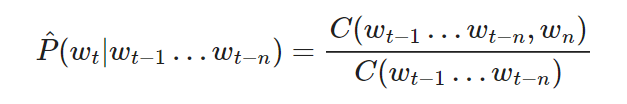

After applying K-smoothing (to handle zero counts)

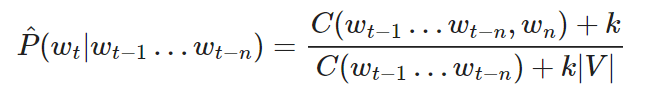

In [16]:
def estimate_probability(word, previous_n_gram, n_gram_counts, n_plus1_gram_counts, vocabulary_size, k=1.0):
  """
  Estimate the probabilites of a next word using the n-gram counts with k-smoothing

  Arguments:
    word: next_word
    previous_n_gram: A sequence of words of length n
    n_gram_counts: Dictionary of counts of n-grams 
    n_plus1_gram_counts: Dictionary of counts of (n+1)-grams
    vocabulary_size: number of words in the vocabulary
    k: a positive constant, smoothing parameter
  Returns:
    A probability
  """
  previous_n_gram = tuple(previous_n_gram)

  previous_n_gram_count = n_gram_counts.get(previous_n_gram, 0)

  denominator = previous_n_gram_count + k * vocabulary_size

  n_plus1_gram = previous_n_gram + tuple([word])

  n_plus1_gram_count = n_plus1_gram_counts.get(n_plus1_gram, 0)

  numerator = n_plus1_gram_count + 1

  probability = numerator / denominator

  return probability 
  

The function defined below loops over all words in vocabulary to calculate probabilities for all possible words.

In [17]:
def estimate_probabilities(previous_n_gram, n_gram_counts, n_plus1_gram_counts, vocabulary, k=1.0):
  """
  This function estimates the probabilites of next words using the n-gram counts with k-smoothing

  Arguments:
    previous_n_gram: A sequence of words of length n 
    n_gram_counts: Dictionary of counts (n+1)-grams
    n_plus1_gram_counts: Dictionary of counts of (n+1)-grams
    vocabulary: List of words
    k: positive constant, smoothing parameter
  Returns:
    A dicitonary mapping from next words to the probability
  """
  previous_n_gram = tuple(previous_n_gram)

  vocabulary = vocabulary + ["<e>", "<unk>"]
  vocabulary_size = len(vocabulary)

  probabilities = {}
  for word in vocabulary:
    probability = estimate_probability(word, previous_n_gram, n_gram_counts, n_plus1_gram_counts, vocabulary_size, k=k)
    probabilities[word] = probability
  
  return probabilities

In [18]:
# Testing the function
sentences = [['i', 'like', 'a', 'cat'],
             ['this', 'dog', 'is', 'like', 'a', 'cat']]
unique_words = list(set(sentences[0] + sentences[1]))
unigram_counts = count_n_grams(sentences, 1)
bigram_counts = count_n_grams(sentences, 2)
estimate_probabilities("a", unigram_counts, bigram_counts, unique_words, k=1)

{'<e>': 0.09090909090909091,
 '<unk>': 0.09090909090909091,
 'a': 0.09090909090909091,
 'cat': 0.2727272727272727,
 'dog': 0.09090909090909091,
 'i': 0.09090909090909091,
 'is': 0.09090909090909091,
 'like': 0.09090909090909091,
 'this': 0.09090909090909091}

Step 3: Count and probability matrix (An intuitive way of presenting the n-gram counts)

In [19]:
def make_count_matrix(n_plus1_gram_counts, vocabulary):
  """
  This function returns count matrices
  """
  vocabulary = vocabulary + ["<e>", "<unk>"]
  
  n_grams = []
  for n_plus1_gram in n_plus1_gram_counts.keys():
    n_gram = n_plus1_gram[0:-1]
    n_grams.append(n_gram)
  n_grams = list(set(n_grams))

  row_index = {n_gram: i for i, n_gram in enumerate(n_grams)}
  col_index = {word: j for j, word in enumerate(vocabulary)}

  nrow = len(n_grams)
  ncol = len(vocabulary)
  count_matrix = np.zeros((nrow, ncol))
  for n_plus1_gram, count in n_plus1_gram_counts.items():
    n_gram = n_plus1_gram[0:-1]
    word = n_plus1_gram[-1]
    if word not in vocabulary:
      continue
    i = row_index[n_gram]
    j = col_index[word]
    count_matrix[i, j] = count

  count_matrix = pd.DataFrame(count_matrix, index=n_grams, columns=vocabulary)
  return count_matrix


In [20]:
# Testing the function
sentences = [['i', 'like', 'a', 'cat'],
                 ['this', 'dog', 'is', 'like', 'a', 'cat']]
unique_words = list(set(sentences[0] + sentences[1]))
bigram_counts = count_n_grams(sentences, 2)

print('bigram counts')
display(make_count_matrix(bigram_counts, unique_words))

bigram counts


,this,cat,a,like,is,dog,i,<e>,<unk>
"(this,)",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
"(cat,)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
"(<s>,)",1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
"(dog,)",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
"(i,)",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
"(like,)",0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
"(is,)",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
"(a,)",0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The following function calculates the probabilities of each word given the previous n-gram, and stores this in matrix form.

In [21]:
def make_probability_matrix(n_plus1_gram_counts, vocabulary, k):
  count_matrix = make_count_matrix(n_plus1_gram_counts, vocabulary)
  count_matrix += k
  prob_matrix = count_matrix.div(count_matrix.sum(axis=1), axis=0)
  return prob_matrix

In [22]:
sentences = [['i', 'like', 'a', 'cat'],
                 ['this', 'dog', 'is', 'like', 'a', 'cat']]
unique_words = list(set(sentences[0] + sentences[1]))
bigram_counts = count_n_grams(sentences, 2)
print("bigram probabilities")
display(make_probability_matrix(bigram_counts, unique_words, k=1))

bigram probabilities


,this,cat,a,like,is,dog,i,<e>,<unk>
"(this,)",0.100000,0.100000,0.100000,0.100000,0.100000,0.200000,0.100000,0.100000,0.100000
"(cat,)",0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.272727,0.090909
"(<s>,)",0.181818,0.090909,0.090909,0.090909,0.090909,0.090909,0.181818,0.090909,0.090909
"(dog,)",0.100000,0.100000,0.100000,0.100000,0.200000,0.100000,0.100000,0.100000,0.100000
"(i,)",0.100000,0.100000,0.100000,0.200000,0.100000,0.100000,0.100000,0.100000,0.100000
"(like,)",0.090909,0.090909,0.272727,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909
"(is,)",0.100000,0.100000,0.100000,0.200000,0.100000,0.100000,0.100000,0.100000,0.100000
"(a,)",0.090909,0.272727,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909


Step 4: Evaluating the model using Perplexity score on the test set

Perplexity is used to tell us whether a set of sentences look like they were written by humans rather than by a simple program choosing words at random. A text that is written by humans is more likely to have lower perplexity, where a text generated by random word choice would have a higher perplexity.<br>Formula to compute the perplexity score: 

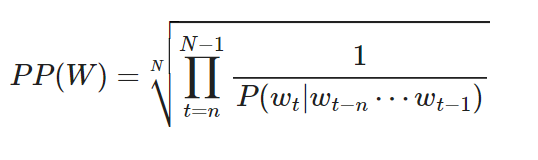

The function below computes the perplexity score given an N-gram count matrix and a sentence.

In [23]:
def calculate_perplexity(sentence, n_gram_counts, n_plus1_gram_counts, vocabulary_size, k=1.0):
  """
  Calculates perplexity for a list of sentences

  Arguments:
    sentence: List of strings
    n_gram_counts: Dictionary of counts of n-grams
    n_plus1_gram_counts: Dictionary of counts of (n+1)-grams
    vocabulary_size: number of unique words in the vocabulary
    k: positive smoothing constant
  Returns:
    Perplexity score
  """
  n = len(list(n_gram_counts.keys())[0])
  
  sentence = ["<s>"] * n + sentence + ["<e>"]
  sentence = tuple(sentence)

  N = len(sentence)
  product_pi = 1.0
  for t in range(n, N):
    n_gram = sentence[t-n:t]
    word = sentence[t]
    probability = estimate_probability(word, n_gram, n_gram_counts, n_plus1_gram_counts, vocabulary_size, k)
    product_pi *= 1 / probability

  perplexity = product_pi ** (1/N)
  
  return perplexity



To handle longer sentences, sum of the log of the probabilities are used and evaluation is performed.

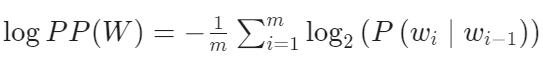

In [24]:
def calculate_perplexity_log(sentence, n_gram_counts, n_plus1_gram_counts, vocabulary_size, k=1.0):
  """
  Calculates perplexity for a list of sentences

  Arguments: 
    sentence: List of strings
    n_gram_counts: Dictionary of counts of n-grams
    n_plus1_gram_counts: Dictionary of counts of (n+1)-grams
    vocabulary_size: number of unique words in the vocabulary
    k: positive smoothing constant
  Returns:
    Perplexity score
  """
  n = len(list(n_gram_counts.keys())[0])

  sentence = ["<s>"] + sentence + ["<e>"]
  sentence = tuple(sentence)

  N = len(sentence)
  log_pi = 0
  for t in range(n, N):
    n_gram = sentence[t-n:t]
    word = sentence[t]
    probability = estimate_probability(word, n_gram, n_gram_counts, n_plus1_gram_counts, vocabulary_size, k)
    log_pi += np.log(probability)

  perplexity = -1/(N - n) * log_pi

  return perplexity

In [34]:
# Testing the fuction
sentences = [['i', 'like', 'a', 'cat'],
             ['this', 'dog', 'is', 'like', 'a', 'cat']]
unique_words = list(set(sentences[0] + sentences[1]))

unigram_counts = count_n_grams(sentences, 1)
bigram_counts = count_n_grams(sentences, 2)

previous_tokens = ["i", "like"]
sample_score = calculate_perplexity(previous_tokens, unigram_counts, bigram_counts, len(unique_words), k=1.0)
print(f"Perplexity score: {sample_score}")
sample_score_log = calculate_perplexity_log(previous_tokens, unigram_counts, bigram_counts, len(unique_words), k=1.0)
print(f"Log perplexity score: {sample_score_log}")

Perplexity score: 3.5676213450081633
Log perplexity score: 1.695865445077461


In [26]:
uqtestLength = 0
for sentences in test_data_preprocessed:
  uqtestLength += len(set(sentences))
uqtestLength

6637379

In [32]:
# Testing the function
uni_counts = count_n_grams(test_data_preprocessed, 1)
bi_counts = count_n_grams(test_data_preprocessed, 2)

tokens = ["i", "like"]
score = calculate_perplexity(tokens, uni_counts, bi_counts, uqtestLength, k=1.0)
print(f"Perplexity score: {score}")
log_score = calculate_perplexity_log(tokens, uni_counts, bi_counts, uqtestLength, k=1.0)
print(f"Log perplexity score: {log_score}")

Perplexity score: 385.7622725601125
Log perplexity score: 7.940295074053086


In [35]:
twenty_counts = count_n_grams(test_data_preprocessed, 20)
twentytwo_counts = count_n_grams(test_data_preprocessed, 22)

tokens = ["i", "like"]
score = calculate_perplexity(tokens, twenty_counts, twentytwo_counts, uqtestLength, k=1.0)
print(f"Perplexity score: {score}")
log_score = calculate_perplexity_log(tokens, twenty_counts, twentytwo_counts, uqtestLength, k=1.0)
print(f"Log perplexity score: {log_score}")

Perplexity score: 7.785174429928315
Log perplexity score: 0.0


When n is a lower number (like 1 or 2) perplexity score is high. As value of n increases perplexity score decreases. This happens due to the size of the test data. However on small samples, we see a smaller value of n gives good perplexity scores.

## Building an auto-complete system

Combining the language models to implement an auto-complete system.

In [36]:
def suggest_a_word(previous_tokens, n_gram_counts, n_plus1_gram_counts, vocabulary, k=1.0, start_with=None):
  """
  Get suggestion for the next word

  Arguments:
    previous_tokens: The sentence you input where each token is a word. Must have length > n
    n_gram_counts: Dictionary of counts of n-grams
    n_plus1_gram_counts: Dictionary pf counts of (n+1)-grams
    vocabulary: List of words
    k: positive constant, smoothing parameter
    start_with: If not None, specifies the first few letters of the next word
  Returns:
    A tuple of string of the most likely next word and corresponding probability
  """
  n = len(list(n_gram_counts.keys())[0])
  previous_n_gram = previous_tokens[-n:]
  
  probabilities = estimate_probabilities(previous_n_gram, n_gram_counts, n_plus1_gram_counts, vocabulary, k)

  suggestion = None

  max_prob = 0 
  for word, prob in probabilities.items():
    if start_with:
      if word.startswith(start_with) == False:
        continue
    if prob > max_prob:
      suggestion = word
      max_prob = prob
  return suggestion, max_prob

In [37]:
# Testing the function
sentences = [['i', 'like', 'a', 'cat'],
             ['this', 'dog', 'is', 'like', 'a', 'cat']]
unique_words = list(set(sentences[0] + sentences[1]))

unigram_counts = count_n_grams(sentences, 1)
bigram_counts = count_n_grams(sentences, 2)

previous_tokens = ["i", "like"]
tmp_suggest1 = suggest_a_word(previous_tokens, unigram_counts, bigram_counts, unique_words, k=1.0)
print(f"The previous words are 'i like',\n\tand the suggested word is `{tmp_suggest1[0]}` with a probability of {tmp_suggest1[1]:.4f}")

print()
# Setting the starts_with
tmp_starts_with = 'c'
tmp_suggest2 = suggest_a_word(previous_tokens, unigram_counts, bigram_counts, unique_words, k=1.0, start_with=tmp_starts_with)
print(f"The previous words are 'i like', the suggestion must start with `{tmp_starts_with}`\n\tand the suggested word is `{tmp_suggest2[0]}` with a probability of {tmp_suggest2[1]:.4f}\n")

The previous words are 'i like',
	and the suggested word is `a` with a probability of 0.2727

The previous words are 'i like', the suggestion must start with `c`
	and the suggested word is `cat` with a probability of 0.0909



The function defined below loop over varioud n-gram models to get multiple suggestions.

In [38]:
def get_suggestions(previous_tokens, n_gram_counts_list, vocabulary, k=1.0, start_with=None):
  """
  This function loops over various n-gram models to get multiple suggestions
  """
  model_counts = len(n_gram_counts_list)
  suggestions = []
  for i in range(model_counts - 1):
    n_gram_counts = n_gram_counts_list[i]
    n_plus1_gram_counts = n_gram_counts_list[i + 1]
    suggestion = suggest_a_word(previous_tokens, n_gram_counts, n_plus1_gram_counts, vocabulary, k, start_with)
    suggestions.append(suggestion)
  return suggestions 

In [39]:
# Testing the function
sentences = [['i', 'like', 'a', 'cat'],
             ['this', 'dog', 'is', 'like', 'a', 'cat']]
unique_words = list(set(sentences[0] + sentences[1]))

unigram_counts = count_n_grams(sentences, 1)
bigram_counts = count_n_grams(sentences, 2)
trigram_counts = count_n_grams(sentences, 3)
quadgram_counts = count_n_grams(sentences, 4)
qintgram_counts = count_n_grams(sentences, 5)

n_gram_counts_list = [unigram_counts, bigram_counts, trigram_counts, quadgram_counts, qintgram_counts]
previous_tokens = ["i", "like"]
tmp_suggest3 = get_suggestions(previous_tokens, n_gram_counts_list, unique_words, k=1.0)

print(f"The previous words are 'i like', the suggestions are:")
display(tmp_suggest3)

The previous words are 'i like', the suggestions are:


[('a', 0.2727272727272727),
 ('a', 0.2),
 ('this', 0.1111111111111111),
 ('this', 0.1111111111111111)]

The following suggests multiple words using n-grams of varying length

In [40]:
n_gram_counts_list = []
for n in range(1,4):
  print("Computing n-gram counts with n = ", n)
  n_model_counts = count_n_grams(train_data_preprocessed, n)
  n_gram_counts_list.append(n_model_counts)

Computing n-gram counts with n =  1
Computing n-gram counts with n =  2
Computing n-gram counts with n =  3


In [41]:
previous_tokens = ["hey", "how", "are", "you"]
tmp_suggest4 = get_suggestions(previous_tokens, n_gram_counts_list, vocabulary, 1.0)
print(f"The previous words are {previous_tokens}, the suggestions are: ")
display(tmp_suggest4)

The previous words are ['hey', 'how', 'are', 'you'], the suggestions are: 


[("'re", 0.047302884806158484), ('?', 0.0123517468564775)]

In [42]:
previous_tokens = ["hey", "how", "are", "you"]
tmp_suggest5 = get_suggestions(previous_tokens, n_gram_counts_list, vocabulary, 1.0, "d")
print(f"The previous words are {previous_tokens}, the suggestions are: ")
display(tmp_suggest5)

The previous words are ['hey', 'how', 'are', 'you'], the suggestions are: 


[('do', 0.017694535931113843), ('doing', 0.0067112523185124074)]

--------------------------------------------------------------------------------------------------------------------------------